## Modeling - noise

*This notebook contains two modeling approaches regarding the background noise data handling - their implementation, testing and evaluation, as well as simple EDA regarding the background noise files. Final modeling approach can be found in modeling-experiments.ipynb notebook.*

In [1]:
import gc
import os
import re
import math
import random
import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm as tqdm
from itertools import compress

from scipy.fftpack import fft
from scipy.io import wavfile
from scipy import signal
from scipy.io import wavfile

import keras
from keras import optimizers, losses, activations, models
from keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Conv1D, GRU
from tensorflow.keras.layers import Input, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

import warnings

random.seed(0)
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
# parameters settings
data_path = '../../data/train/audio'
labels = os.listdir(data_path)
CLASSES = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go'] 
SAMPLING_RATE = 16000

EPOCHS = 30
PATIENCE=int(EPOCHS/3)
BATCH_SIZE = 128
MIN_DELTA=1e-4
LR = 1e-4
DROPOUT = 0.2
NOISE_RATIO = 0.1

In [3]:
# data processing functions
def pad_audio(samples):
    return np.pad(samples, pad_width=(SAMPLING_RATE - len(samples), 0), mode='constant', constant_values=(0, 0))


def chop_audio(samples):
    return samples[:SAMPLING_RATE]


def split_audio(sample_rate, samples):
    """ Splits audio file to multiple with (up to) fixed 1s length """
    duration = float(len(samples)/sample_rate)
    n_samples = math.ceil(duration)
    return np.array_split(samples, n_samples)

In [4]:
# label encoding
def assign_unknown_label(labels, classes=CLASSES):
    new_labels = []
    for label in labels:
        if label not in classes:
            new_labels.append('unknown')
        else:
            new_labels.append(label)
    return new_labels

def encode_labels(labels):
    return pd.get_dummies(pd.Series(labels))

In [5]:
# data processing and plots
def specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    _, _, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return np.log(spec.T.astype(np.float32) + eps)


def plot_model_history(history, title: str) -> None:
    """
    Plotting the learning curve of Keras model, broken down into loss curve and accuracy curve, 
    for both training and validation data.

    Args:
        history : Object returned by the .fit method of Keras model.
        title (str): Title of the plots.
    """
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 

    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')

    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    fig.suptitle(title, size=15)
    plt.show()

In [6]:
# model framework
def rnn_network(input_dim, output_dim, rnn_layer):

    input_data = Input(name='input', shape=input_dim, dtype='float32')

    x = Conv1D(filters=256, kernel_size=10, strides=4, name='conv1d')(input_data)
    x = BatchNormalization(name='b_norm')(x)
    x = Activation('relu', name='activation')(x)
    x = Dropout(DROPOUT, name='dropout_1')(x)
    x = rnn_layer(128, activation='relu', return_sequences=True, dropout=DROPOUT, name='rnn_1')(x)
    x = rnn_layer(128, activation='relu', return_sequences=False, dropout=DROPOUT, name='rnn_2')(x)
    x = Dense(units=64, activation='relu', name='dense')(x)
    x = Dropout(DROPOUT, name='dropout_2')(x)

    output_data = Dense(units=output_dim, activation='softmax', name='softmax')(x)

    model = Model(inputs=input_data, outputs=output_data, name=str(rnn_layer).split(".")[-1].split("'")[0])
    model.compile(loss='categorical_crossentropy', optimizer=OPT, metrics=['accuracy'])

    return model

In [7]:
def plot_heatmaps(models_results: list, title: str=None) -> None:
    """
    Plot heatmaps based on the confusion matrices of a given models.

    Args:
        models_results (list): List of confusion matrices of the evaluated models.
        title (str): Title of the plots.
    """
    fig, axes = plt.subplots(1,3,figsize=(18,6))
    models = ['SimpleRNN', 'LSTM', 'GRU']
    for i in range(3):
        sns.heatmap(models_results[i], annot=True, cmap="Blues", ax=axes[i], fmt='d', annot_kws={"size": 12})
        axes[i].set_title(models[i], size=15)
        axes[i].set_xticklabels(axes[i].get_xmajorticklabels(), fontsize = 12)
        axes[i].set_yticklabels(axes[i].get_xmajorticklabels(), fontsize = 12)
        cax = plt.gcf().axes[-1]
        cax.tick_params(labelsize=12)

    plt.tight_layout()
    plt.show()

# <span style='font-family:Georgia'> 1. Data loading & preparation

## <span style='font-family:Georgia'> 1.1. Check on length distributions of recordings from classes other than background_noise & sampling rates consistency

In [8]:
duration_checklist = []
sampling_rates_checklist = []

for label in tqdm([l for l in labels if l != '_background_noise_']):

    files = [f for f in os.listdir(data_path + '/'+ label) if f.endswith('.wav')]
    
    for file in files:
        sample_rate, samples = wavfile.read(data_path + "/" + label + "/" + file)
        duration = float(len(samples)/sample_rate)
        
        duration_checklist.append(duration)
        sampling_rates_checklist.append(sample_rate)

  0%|          | 0/30 [00:00<?, ?it/s]

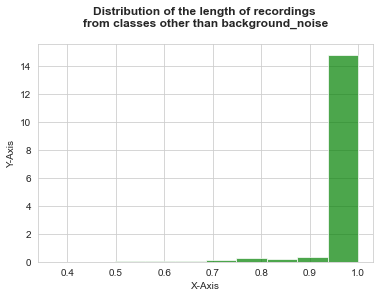

In no class other than background noise there are recordings longer than 1s.
Sampling rates are consistent and equal to: 16000


In [9]:
num_bins = 10
x = np.array(duration_checklist)

plt.hist(x, num_bins, 
         density = 1, 
         color ='green',
         alpha = 0.7)
  
plt.xlabel('X-Axis')
plt.ylabel('Y-Axis')
  
plt.title('Distribution of the length of recordings \nfrom classes other than background_noise\n',
          fontweight ="bold")
  
plt.show()

if np.sum(x>1) > 0:
    print("There is a class other than background noise with recordings longer than 1s.")
else:
    print("In no class other than background noise there are recordings longer than 1s.")
    
if np.sum(np.array(sampling_rates_checklist)!=SAMPLING_RATE) > 0:
    print("Sampling rates are not consistent")
else:
    print(f"Sampling rates are consistent and equal to: {SAMPLING_RATE}")

## <span style='font-family:Georgia'> 1.2. Check of length distributions of recordings from background_noise class

In [10]:
duration_checklist = []
sampling_rates_checklist = []
label = '_background_noise_'

files = [f for f in os.listdir(data_path + '/'+ label) if f.endswith('.wav')]

for file in files:
    sample_rate, samples = wavfile.read(data_path + "/" + label + "/" + file)
    duration = float(len(samples)/sample_rate)

    duration_checklist.append(duration)
    sampling_rates_checklist.append(sample_rate)

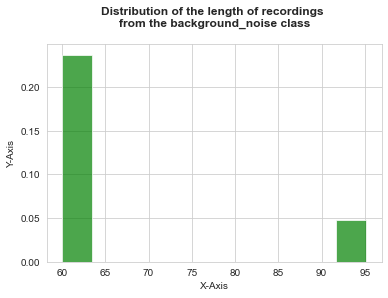

Sampling rates are consistent and equal to: 16000


In [11]:
num_bins = 10
x = np.array(duration_checklist)

plt.hist(x, num_bins, 
         density = 1, 
         color ='green',
         alpha = 0.7)
  
plt.xlabel('X-Axis')
plt.ylabel('Y-Axis')
  
plt.title('Distribution of the length of recordings \nfrom the background_noise class\n',
          fontweight ="bold")
  
plt.show()

if np.sum(np.array(sampling_rates_checklist)!=SAMPLING_RATE) > 0:
    print("Sampling rates are not consistent")
else:
    print(f"Sampling rates are consistent and equal to: {SAMPLING_RATE}")

## <span style='font-family:Georgia'> 1.3. Noisy data loading

In [13]:
label = '_background_noise_'
files = [f for f in os.listdir(data_path + '/'+ label) if f.endswith('.wav')]
one_sec_background_noise_specgrams = []

for file in tqdm(files):
    _, samples = wavfile.read(data_path + "/" + label + "/" + file)
    duration = float(len(samples)/SAMPLING_RATE)

    # Do not distinguish between noise classes
    one_sec_background_noise = split_audio(
            sample_rate=SAMPLING_RATE, samples=samples
        )
    
    for item in one_sec_background_noise:
        duration = float(len(item)/SAMPLING_RATE)
        if duration < 1: item = pad_audio(item)        
        
        one_sec_background_noise_specgrams.append(
            specgram(item, SAMPLING_RATE)
        )

  0%|          | 0/6 [00:00<?, ?it/s]

## <span style='font-family:Georgia'> 1.4. Noise-free data loading

In [14]:
validation_list = pd.read_csv('../../data/train/validation_list.txt', sep="\t", header=None)[0].tolist()
testing_list = pd.read_csv('../../data/train/testing_list.txt', sep="\t", header=None)[0].tolist()

In [15]:
print('Training: ', 64721 - len(validation_list) - len(testing_list))
print('Validation: ', len(validation_list))
print('Testing: ', len(testing_list))

Training:  51088
Validation:  6798
Testing:  6835


In [16]:
train_labels = []
train_specgrams = []
val_labels = []
val_specgrams = []
test_labels = []
test_specgrams = []

for label in tqdm([l for l in labels if l != '_background_noise_']):

    files = [f for f in os.listdir(data_path + '/'+ label) if f.endswith('.wav')]
    
    for file in tqdm(files):
        _, samples = wavfile.read(data_path + "/" + label + "/" + file)
        duration = float(len(samples)/SAMPLING_RATE)
                
        if duration < 1: samples = pad_audio(samples)
            
        if (label + "/" + file) in validation_list: 
            val_labels.append(label)
            val_specgrams.append(specgram(samples, SAMPLING_RATE))
        elif (label + "/" + file) in testing_list: 
            test_labels.append(label)
            test_specgrams.append(specgram(samples, SAMPLING_RATE))
        else:
            train_labels.append(label)
            train_specgrams.append(specgram(samples, SAMPLING_RATE))

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1713 [00:00<?, ?it/s]

  0%|          | 0/1731 [00:00<?, ?it/s]

  0%|          | 0/1733 [00:00<?, ?it/s]

  0%|          | 0/1746 [00:00<?, ?it/s]

  0%|          | 0/2359 [00:00<?, ?it/s]

  0%|          | 0/2352 [00:00<?, ?it/s]

  0%|          | 0/2357 [00:00<?, ?it/s]

  0%|          | 0/2372 [00:00<?, ?it/s]

  0%|          | 0/2372 [00:00<?, ?it/s]

  0%|          | 0/1742 [00:00<?, ?it/s]

  0%|          | 0/1750 [00:00<?, ?it/s]

  0%|          | 0/2353 [00:00<?, ?it/s]

  0%|          | 0/1746 [00:00<?, ?it/s]

  0%|          | 0/2364 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2357 [00:00<?, ?it/s]

  0%|          | 0/2367 [00:00<?, ?it/s]

  0%|          | 0/2370 [00:00<?, ?it/s]

  0%|          | 0/2367 [00:00<?, ?it/s]

  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/1734 [00:00<?, ?it/s]

  0%|          | 0/2369 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/2356 [00:00<?, ?it/s]

  0%|          | 0/1733 [00:00<?, ?it/s]

  0%|          | 0/2373 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/1745 [00:00<?, ?it/s]

  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/2376 [00:00<?, ?it/s]

## <span style='font-family:Georgia'> 1.5. Data labeling

### <span style='font-family:Georgia'> 1.5.1. Noise-free data labeling

In [17]:
X_train = np.array(train_specgrams)
X_val = np.array(val_specgrams)
X_test = np.array(test_specgrams)

Y_train = assign_unknown_label(train_labels)
Y_val = assign_unknown_label(val_labels)
Y_test = assign_unknown_label(test_labels)

# Labels encoding
Y_train = np.array(encode_labels(Y_train).values)
Y_val = np.array(encode_labels(Y_val).values)
Y_test = np.array(encode_labels(Y_test).values)

### <span style='font-family:Georgia'> 1.5.2. Approach 1 - taking `background_noise` observations as separate `silence` class

In [19]:
# Split noise into 3 disjoint subsets (train, valid & test sets)
N = 64721
valid_ratio = np.round(len(validation_list)/N, 2)
test_ratio = np.round(len(testing_list)/N, 2)
train_ratio = 1 - (valid_ratio+test_ratio)

sets_list = ["train", "val", "test"]
obs_split = np.array(random.choices(sets_list, weights=(train_ratio, valid_ratio, test_ratio), k=N))
train_mask, val_mask, test_mask = obs_split == "train", obs_split == "val", obs_split == "test"

In [20]:
train_noise = list(compress(one_sec_background_noise_specgrams, train_mask))
print(f'Number of observations assigned to train set: {len(train_noise)}')

val_noise = list(compress(one_sec_background_noise_specgrams, val_mask))
print(f'Number of observations assigned to validation set: {len(val_noise)}')

test_noise = list(compress(one_sec_background_noise_specgrams, test_mask))
print(f'Number of observations assigned to test set: {len(test_noise)}')

Number of observations assigned to train set: 303
Number of observations assigned to validation set: 48
Number of observations assigned to test set: 51


In [21]:
train_specgrams_1 = train_specgrams + train_noise
train_labels_1 = train_labels + ['silence' for i in range(len(train_noise))]

val_specgrams_1 = val_specgrams + val_noise
val_labels_1 = val_labels + ['silence' for i in range(len(val_noise))]

test_specgrams_1 = test_specgrams + test_noise
test_labels_1 = test_labels + ['silence' for i in range(len(test_noise))]

In [22]:
x_train_1 = np.array(train_specgrams_1)
print(x_train_1.shape)

x_val_1 = np.array(val_specgrams_1)
print(x_val_1.shape)

x_test_1 = np.array(test_specgrams_1)
print(x_test_1.shape)

(51391, 99, 161)
(6846, 99, 161)
(6886, 99, 161)


In [23]:
classes=CLASSES+['silence']

y_train_1 = assign_unknown_label(train_labels_1, classes=classes)
print(np.unique(y_train_1))

y_val_1 = assign_unknown_label(val_labels_1, classes=classes)
print(np.unique(y_val_1))

y_test_1 = assign_unknown_label(test_labels_1, classes=classes)
print(np.unique(y_test_1))

['down' 'go' 'left' 'no' 'off' 'on' 'right' 'silence' 'stop' 'unknown'
 'up' 'yes']
['down' 'go' 'left' 'no' 'off' 'on' 'right' 'silence' 'stop' 'unknown'
 'up' 'yes']
['down' 'go' 'left' 'no' 'off' 'on' 'right' 'silence' 'stop' 'unknown'
 'up' 'yes']


In [24]:
del train_specgrams_1, val_specgrams_1, test_specgrams_1
del train_labels_1, val_labels_1, test_labels_1
gc.collect()

7311

In [25]:
# Labels encoding
y_train_1 = np.array(encode_labels(y_train_1).values)
y_val_1 = np.array(encode_labels(y_val_1).values)
y_test_1 = np.array(encode_labels(y_test_1).values)

### <span style='font-family:Georgia'> 1.5.2. Approach 2 - noising the training subset(s) with the 'background_noise' class observations

In [30]:
train_labels_summary = pd.Series(train_labels).value_counts()
n = math.floor(NOISE_RATIO*train_labels_summary.sum())
noised_labels = random.choices(train_labels, k=n)

summary = pd.DataFrame(train_labels_summary, columns=["obs_cnt"])
summary["noise_cnt"] = pd.Series(noised_labels).value_counts()
summary["noise_ratio"] = summary["noise_cnt"] / summary["obs_cnt"]
summary

,obs_cnt,noise_cnt,noise_ratio
one,1892,204,0.107822
stop,1885,185,0.098143
nine,1875,170,0.090667
seven,1875,173,0.092267
two,1873,167,0.089162
zero,1866,166,0.088960
on,1864,183,0.098176
six,1863,181,0.097155
go,1861,163,0.087587
yes,1860,191,0.102688


In [31]:
train_specgrams_2 = train_specgrams + random.choices(one_sec_background_noise_specgrams, k=n)
train_labels_2 = train_labels + noised_labels

In [32]:
x_train_2 = np.array(train_specgrams_2)
print(x_train_2.shape)

(56196, 99, 161)


In [33]:
y_train_2 = assign_unknown_label(train_labels_2)
print(np.unique(y_train_2))

['down' 'go' 'left' 'no' 'off' 'on' 'right' 'stop' 'unknown' 'up' 'yes']


In [34]:
# Labels encoding
y_train_2 = np.array(encode_labels(y_train_2).values)

In [35]:
del train_specgrams_2, train_labels_2
del train_specgrams, val_specgrams, test_specgrams
del train_labels, val_labels, test_labels

gc.collect()

0

# <span style='font-family:Georgia'> 2. Modeling

## <span style='font-family:Georgia'> 2.1. Approach 1 - taking `background_noise` observations as separate `silence` class

In [44]:
x_train, x_val, x_test = x_train_1, x_val_1, x_test_1
y_train, y_val, y_test = y_train_1, y_val_1, y_test_1

In [45]:
# hyperparameters set-up
INPUT_DIM = (x_train.shape[1], x_train.shape[2])
OUTPUT_DIM = y_train.shape[1]

OPT = Adam(learning_rate=LR, clipnorm=1.0)
early_stop = EarlyStopping(monitor='val_accuracy', patience=PATIENCE, min_delta=MIN_DELTA)

### <span style='font-family:Georgia'> 2.1.1 SimpleRNN

In [46]:
model_simple = rnn_network(INPUT_DIM, OUTPUT_DIM, SimpleRNN)
model_simple.summary()

Model: "SimpleRNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 99, 161)]         0         
                                                                 
 conv1d (Conv1D)             (None, 23, 256)           412416    
                                                                 
 b_norm (BatchNormalization)  (None, 23, 256)          1024      
                                                                 
 activation (Activation)     (None, 23, 256)           0         
                                                                 
 dropout_1 (Dropout)         (None, 23, 256)           0         
                                                                 
 rnn_1 (SimpleRNN)           (None, 23, 128)           49280     
                                                                 
 rnn_2 (SimpleRNN)           (None, 128)               32

In [47]:
K.clear_session()

In [48]:
history_simple = model_simple.fit(x_train, y_train,
                                  batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,
                                  validation_data=(x_val, y_val),
                                  callbacks=[early_stop]
                       )

Epoch 1/30
402/402 [==============================] - 80s 195ms/step - loss: 1.5360 - accuracy: 0.6166 - val_loss: 1.3539 - val_accuracy: 0.6214
Epoch 2/30
402/402 [==============================] - 67s 166ms/step - loss: 1.3178 - accuracy: 0.6304 - val_loss: 1.1997 - val_accuracy: 0.6245
Epoch 3/30
402/402 [==============================] - 64s 160ms/step - loss: 1.2162 - accuracy: 0.6345 - val_loss: 1.1192 - val_accuracy: 0.6426
Epoch 4/30
402/402 [==============================] - 65s 162ms/step - loss: 1.1134 - accuracy: 0.6461 - val_loss: 1.1509 - val_accuracy: 0.6160
Epoch 5/30
402/402 [==============================] - 64s 159ms/step - loss: 0.9962 - accuracy: 0.6735 - val_loss: 0.8455 - val_accuracy: 0.7140
Epoch 6/30
402/402 [==============================] - 77s 192ms/step - loss: 0.8502 - accuracy: 0.7179 - val_loss: 0.6807 - val_accuracy: 0.7720
Epoch 7/30
402/402 [==============================] - 65s 163ms/step - loss: 0.7093 - accuracy: 0.7648 - val_loss: 0.6144 - val_ac

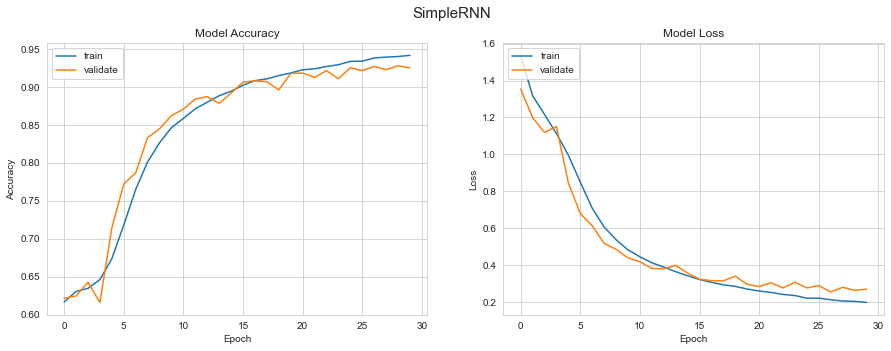

In [49]:
plot_model_history(history_simple, 'SimpleRNN')

### <span style='font-family:Georgia'> 2.1.2. LSTM

In [50]:
model_lstm = rnn_network(INPUT_DIM, OUTPUT_DIM, LSTM)
model_lstm.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 99, 161)]         0         
                                                                 
 conv1d (Conv1D)             (None, 23, 256)           412416    
                                                                 
 b_norm (BatchNormalization)  (None, 23, 256)          1024      
                                                                 
 activation (Activation)     (None, 23, 256)           0         
                                                                 
 dropout_1 (Dropout)         (None, 23, 256)           0         
                                                                 
 rnn_1 (LSTM)                (None, 23, 128)           197120    
                                                                 
 rnn_2 (LSTM)                (None, 128)               131584 

In [51]:
K.clear_session()

In [52]:
history_lstm = model_lstm.fit(x_train, y_train,
                              batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,
                              validation_data=(x_val, y_val),
                              callbacks=[early_stop]
                       )

Epoch 1/30
402/402 [==============================] - 80s 194ms/step - loss: 1.1374 - accuracy: 0.6693 - val_loss: 0.7147 - val_accuracy: 0.7654
Epoch 2/30
402/402 [==============================] - 77s 192ms/step - loss: 0.6352 - accuracy: 0.7980 - val_loss: 0.5158 - val_accuracy: 0.8444
Epoch 3/30
402/402 [==============================] - 81s 200ms/step - loss: 0.4648 - accuracy: 0.8558 - val_loss: 0.3757 - val_accuracy: 0.8881
Epoch 4/30
402/402 [==============================] - 82s 203ms/step - loss: 0.3775 - accuracy: 0.8824 - val_loss: 0.3408 - val_accuracy: 0.8926
Epoch 5/30
402/402 [==============================] - 80s 199ms/step - loss: 0.3341 - accuracy: 0.8964 - val_loss: 0.3204 - val_accuracy: 0.9042
Epoch 6/30
402/402 [==============================] - 76s 189ms/step - loss: 0.2988 - accuracy: 0.9069 - val_loss: 0.3208 - val_accuracy: 0.9027
Epoch 7/30
402/402 [==============================] - 79s 197ms/step - loss: 0.2733 - accuracy: 0.9161 - val_loss: 0.2767 - val_ac

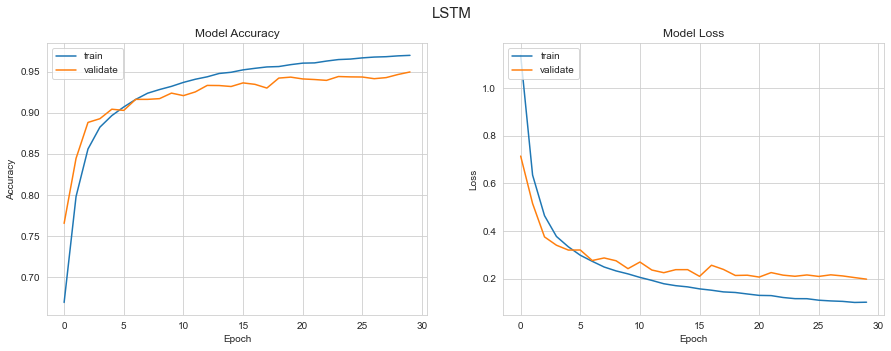

In [53]:
plot_model_history(history_lstm, 'LSTM')

### <span style='font-family:Georgia'> 2.1.3. GRU

In [54]:
model_gru = rnn_network(INPUT_DIM, OUTPUT_DIM, GRU)
model_gru.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 99, 161)]         0         
                                                                 
 conv1d (Conv1D)             (None, 23, 256)           412416    
                                                                 
 b_norm (BatchNormalization)  (None, 23, 256)          1024      
                                                                 
 activation (Activation)     (None, 23, 256)           0         
                                                                 
 dropout_1 (Dropout)         (None, 23, 256)           0         
                                                                 
 rnn_1 (GRU)                 (None, 23, 128)           148224    
                                                                 
 rnn_2 (GRU)                 (None, 128)               99072   

In [55]:
K.clear_session()

In [56]:
history_gru = model_gru.fit(x_train, y_train,
                            batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,
                            validation_data=(x_val, y_val),
                            callbacks=[early_stop]
                       )

Epoch 1/30
402/402 [==============================] - 76s 184ms/step - loss: 1.0365 - accuracy: 0.6943 - val_loss: 0.5275 - val_accuracy: 0.8319
Epoch 2/30
402/402 [==============================] - 73s 182ms/step - loss: 0.4751 - accuracy: 0.8449 - val_loss: 0.3581 - val_accuracy: 0.8852
Epoch 3/30
402/402 [==============================] - 77s 192ms/step - loss: 0.3621 - accuracy: 0.8861 - val_loss: 0.3083 - val_accuracy: 0.9034
Epoch 4/30
402/402 [==============================] - 79s 197ms/step - loss: 0.3064 - accuracy: 0.9030 - val_loss: 0.2689 - val_accuracy: 0.9159
Epoch 5/30
402/402 [==============================] - 73s 182ms/step - loss: 0.2697 - accuracy: 0.9161 - val_loss: 0.2626 - val_accuracy: 0.9195
Epoch 6/30
402/402 [==============================] - 117s 290ms/step - loss: 0.2473 - accuracy: 0.9235 - val_loss: 0.2412 - val_accuracy: 0.9238
Epoch 7/30
402/402 [==============================] - 105s 260ms/step - loss: 0.2313 - accuracy: 0.9274 - val_loss: 0.2392 - val_

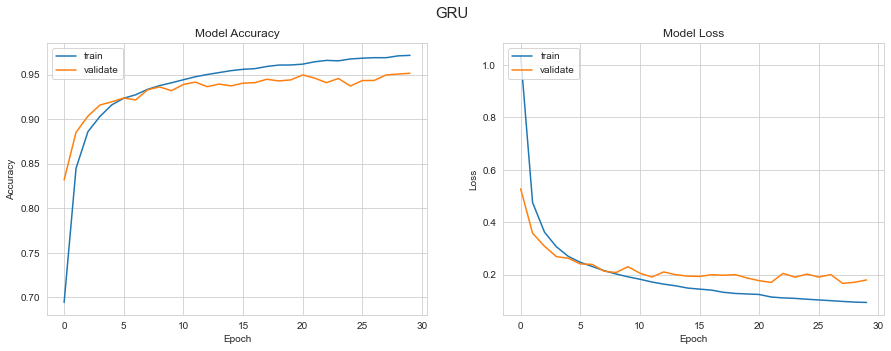

In [57]:
plot_model_history(history_gru, 'GRU')

### <span style='font-family:Georgia'> 2.1.4. Evaluation

In [58]:
y_pred_test_1 = model_simple.predict(x_test)
y_pred_test_classes_1 = np.argmax(y_pred_test_1, axis=-1)

y_pred_test_2 = model_lstm.predict(x_test)
y_pred_test_classes_2 = np.argmax(y_pred_test_2, axis=-1)

y_pred_test_3 = model_gru.predict(x_test)
y_pred_test_classes_3 = np.argmax(y_pred_test_3, axis=-1)

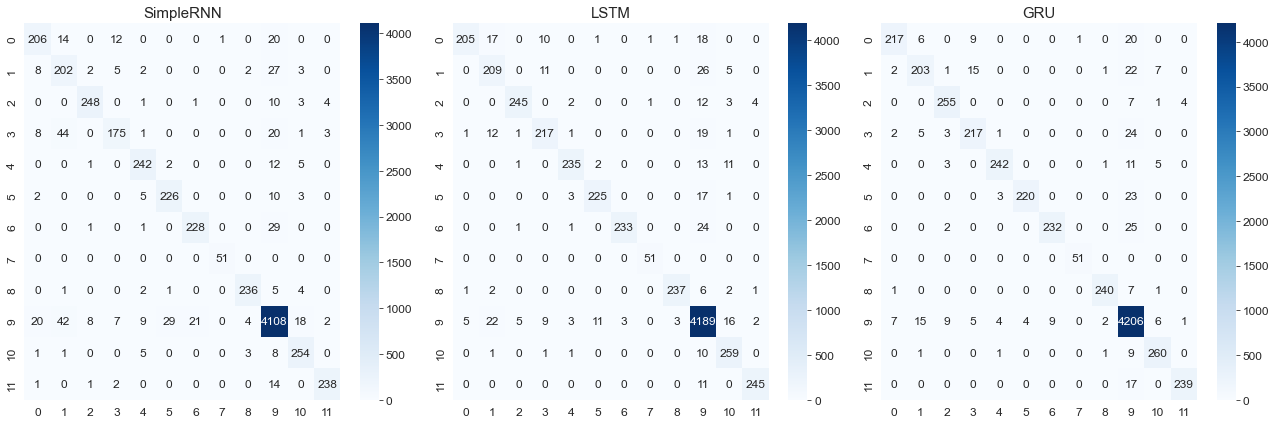

In [59]:
models_results = [pd.DataFrame(confusion_matrix(np.argmax(y_test, axis=-1), y_pred_test_classes_1)),
                  pd.DataFrame(confusion_matrix(np.argmax(y_test, axis=-1), y_pred_test_classes_2)),
                  pd.DataFrame(confusion_matrix(np.argmax(y_test, axis=-1), y_pred_test_classes_3))]
plot_heatmaps(models_results)

(array([ 504.,  267.,  252.,  262.,  246.,  259.,   51.,  249., 4268.,
         528.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <BarContainer object of 10 artists>)

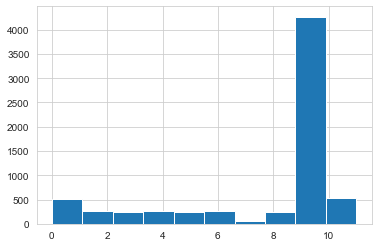

In [60]:
plt.hist(np.argmax(y_test, axis=-1))

## <span style='font-family:Georgia'> 2.2. Approach 2 - noising the training subset(s) with the 'background_noise' class observations

In [61]:
x_train, x_val, x_test = x_train_2, X_val, X_test
y_train, y_val, y_test = y_train_2, Y_val, Y_test

In [62]:
# hyperparameters set-up
INPUT_DIM = (x_train.shape[1], x_train.shape[2])
OUTPUT_DIM = y_train.shape[1]

early_stop = EarlyStopping(monitor='val_accuracy', patience=PATIENCE, min_delta=MIN_DELTA)
OPT = Adam(learning_rate=LR, clipnorm=1.0)

### <span style='font-family:Georgia'> 2.2.1. SimpleRNN

In [63]:
model_simple = rnn_network(INPUT_DIM, OUTPUT_DIM, SimpleRNN)
model_simple.summary()

Model: "SimpleRNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 99, 161)]         0         
                                                                 
 conv1d (Conv1D)             (None, 23, 256)           412416    
                                                                 
 b_norm (BatchNormalization)  (None, 23, 256)          1024      
                                                                 
 activation (Activation)     (None, 23, 256)           0         
                                                                 
 dropout_1 (Dropout)         (None, 23, 256)           0         
                                                                 
 rnn_1 (SimpleRNN)           (None, 23, 128)           49280     
                                                                 
 rnn_2 (SimpleRNN)           (None, 128)               32

In [64]:
K.clear_session()

In [65]:
history_simple = model_simple.fit(x_train, y_train,
                                  batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,
                                  validation_data=(x_val, y_val),
                                  callbacks=[early_stop]
                       )

Epoch 1/30
440/440 [==============================] - 57s 126ms/step - loss: 1.5441 - accuracy: 0.6063 - val_loss: 1.3295 - val_accuracy: 0.6209
Epoch 2/30
440/440 [==============================] - 51s 115ms/step - loss: 1.2973 - accuracy: 0.6357 - val_loss: 1.1744 - val_accuracy: 0.6219
Epoch 3/30
440/440 [==============================] - 52s 118ms/step - loss: 1.2047 - accuracy: 0.6356 - val_loss: 1.0628 - val_accuracy: 0.6356
Epoch 4/30
440/440 [==============================] - 51s 115ms/step - loss: 1.0388 - accuracy: 0.6653 - val_loss: 0.7625 - val_accuracy: 0.7393
Epoch 5/30
440/440 [==============================] - 48s 110ms/step - loss: 0.8569 - accuracy: 0.7235 - val_loss: 0.6248 - val_accuracy: 0.7920
Epoch 6/30
440/440 [==============================] - 48s 110ms/step - loss: 0.7370 - accuracy: 0.7682 - val_loss: 0.5452 - val_accuracy: 0.8201
Epoch 7/30
440/440 [==============================] - 50s 114ms/step - loss: 0.6628 - accuracy: 0.7937 - val_loss: 0.4805 - val_ac

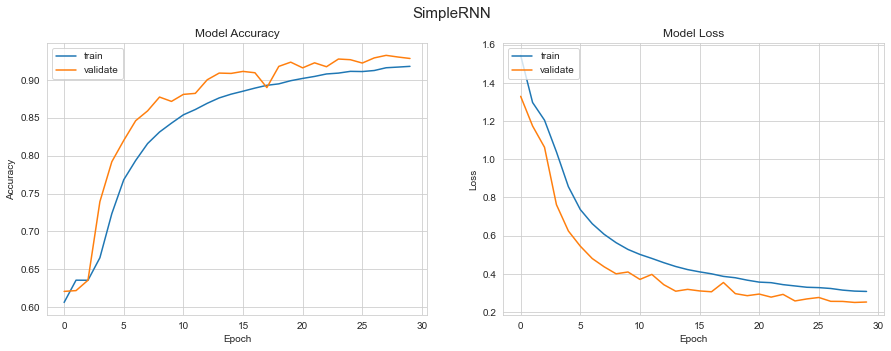

In [66]:
plot_model_history(history_simple, 'SimpleRNN')

### <span style='font-family:Georgia'> 2.2.2. LSTM

In [67]:
model_lstm = rnn_network(INPUT_DIM, OUTPUT_DIM, LSTM)
model_lstm.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 99, 161)]         0         
                                                                 
 conv1d (Conv1D)             (None, 23, 256)           412416    
                                                                 
 b_norm (BatchNormalization)  (None, 23, 256)          1024      
                                                                 
 activation (Activation)     (None, 23, 256)           0         
                                                                 
 dropout_1 (Dropout)         (None, 23, 256)           0         
                                                                 
 rnn_1 (LSTM)                (None, 23, 128)           197120    
                                                                 
 rnn_2 (LSTM)                (None, 128)               131584 

In [68]:
K.clear_session()

In [69]:
history_lstm = model_lstm.fit(x_train, y_train,
                              batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,
                              validation_data=(x_val, y_val),
                              callbacks=[early_stop]
                       )

Epoch 1/30
440/440 [==============================] - 110s 246ms/step - loss: 1.2071 - accuracy: 0.6613 - val_loss: 0.7771 - val_accuracy: 0.7482
Epoch 2/30
440/440 [==============================] - 96s 218ms/step - loss: 0.7450 - accuracy: 0.7727 - val_loss: 0.4822 - val_accuracy: 0.8533
Epoch 3/30
440/440 [==============================] - 102s 231ms/step - loss: 0.5748 - accuracy: 0.8305 - val_loss: 0.3752 - val_accuracy: 0.8848
Epoch 4/30
440/440 [==============================] - 101s 229ms/step - loss: 0.4941 - accuracy: 0.8571 - val_loss: 0.3607 - val_accuracy: 0.8938
Epoch 5/30
440/440 [==============================] - 97s 221ms/step - loss: 0.4427 - accuracy: 0.8731 - val_loss: 0.3331 - val_accuracy: 0.8920
Epoch 6/30
440/440 [==============================] - 102s 232ms/step - loss: 0.4110 - accuracy: 0.8830 - val_loss: 0.3078 - val_accuracy: 0.9109
Epoch 7/30
440/440 [==============================] - 100s 228ms/step - loss: 0.3849 - accuracy: 0.8911 - val_loss: 0.2835 - v

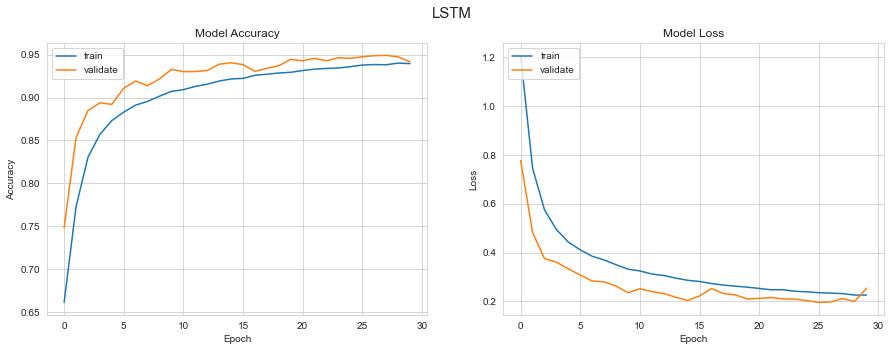

In [70]:
plot_model_history(history_lstm, 'LSTM')

### <span style='font-family:Georgia'> 2.2.3. GRU

In [71]:
model_gru = rnn_network(INPUT_DIM, OUTPUT_DIM, GRU)
model_gru.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 99, 161)]         0         
                                                                 
 conv1d (Conv1D)             (None, 23, 256)           412416    
                                                                 
 b_norm (BatchNormalization)  (None, 23, 256)          1024      
                                                                 
 activation (Activation)     (None, 23, 256)           0         
                                                                 
 dropout_1 (Dropout)         (None, 23, 256)           0         
                                                                 
 rnn_1 (GRU)                 (None, 23, 128)           148224    
                                                                 
 rnn_2 (GRU)                 (None, 128)               99072   

In [72]:
K.clear_session()

In [73]:
history_gru = model_gru.fit(x_train, y_train,
                            batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,
                            validation_data=(x_val, y_val),
                            callbacks=[early_stop]
                       )

Epoch 1/30
440/440 [==============================] - 89s 198ms/step - loss: 1.1607 - accuracy: 0.6733 - val_loss: 0.6245 - val_accuracy: 0.7948
Epoch 2/30
440/440 [==============================] - 90s 205ms/step - loss: 0.6185 - accuracy: 0.8125 - val_loss: 0.3779 - val_accuracy: 0.8835
Epoch 3/30
440/440 [==============================] - 87s 197ms/step - loss: 0.4794 - accuracy: 0.8585 - val_loss: 0.3116 - val_accuracy: 0.8994
Epoch 4/30
440/440 [==============================] - 87s 197ms/step - loss: 0.4231 - accuracy: 0.8791 - val_loss: 0.2692 - val_accuracy: 0.9162
Epoch 5/30
440/440 [==============================] - 91s 207ms/step - loss: 0.3858 - accuracy: 0.8911 - val_loss: 0.2600 - val_accuracy: 0.9157
Epoch 6/30
440/440 [==============================] - 88s 201ms/step - loss: 0.3642 - accuracy: 0.8974 - val_loss: 0.2476 - val_accuracy: 0.9242
Epoch 7/30
440/440 [==============================] - 87s 198ms/step - loss: 0.3467 - accuracy: 0.9029 - val_loss: 0.2290 - val_ac

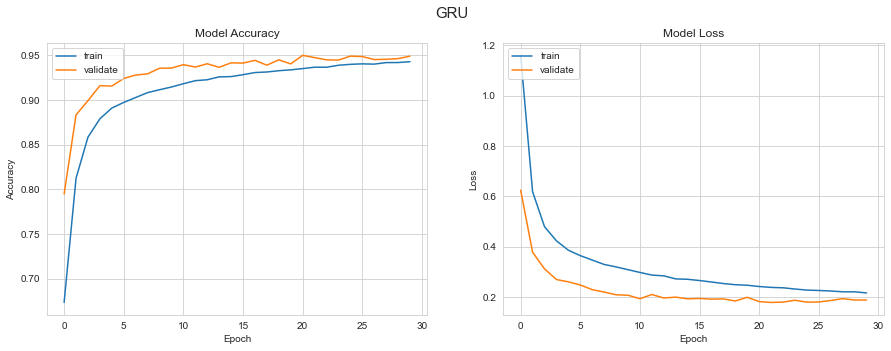

In [74]:
plot_model_history(history_gru, 'GRU')

### <span style='font-family:Georgia'> 2.2.4. Evaluation

In [75]:
y_pred_test_1 = model_simple.predict(x_test)
y_pred_test_classes_1 = np.argmax(y_pred_test_1, axis=-1)

y_pred_test_2 = model_lstm.predict(x_test)
y_pred_test_classes_2 = np.argmax(y_pred_test_2, axis=-1)

y_pred_test_3 = model_gru.predict(x_test)
y_pred_test_classes_3 = np.argmax(y_pred_test_3, axis=-1)

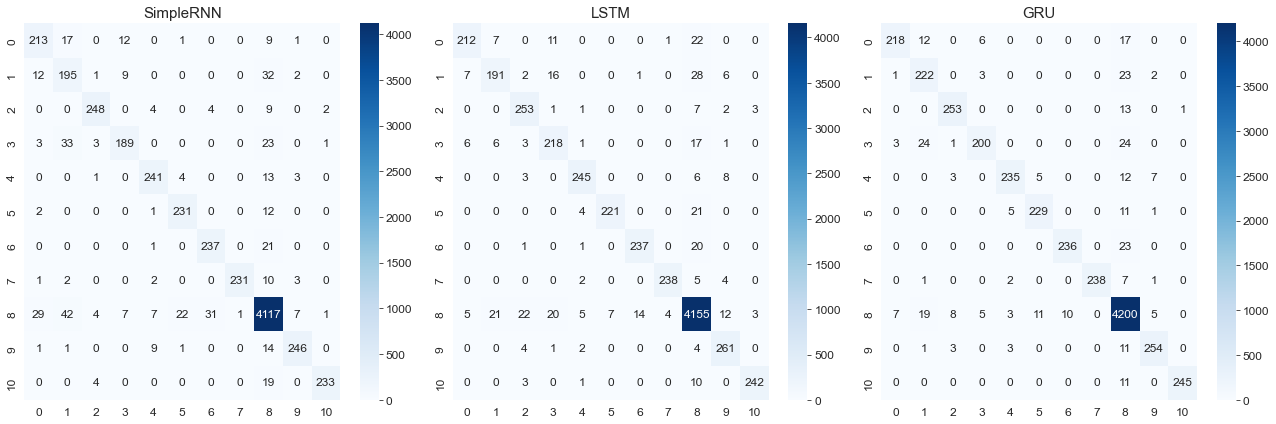

In [76]:
models_results = [pd.DataFrame(confusion_matrix(np.argmax(y_test, axis=-1), y_pred_test_classes_1)),
                  pd.DataFrame(confusion_matrix(np.argmax(y_test, axis=-1), y_pred_test_classes_2)),
                  pd.DataFrame(confusion_matrix(np.argmax(y_test, axis=-1), y_pred_test_classes_3))]
plot_heatmaps(models_results)

(array([ 253.,  251.,  267.,  252.,  262.,  246.,  259.,  249., 4268.,
         528.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

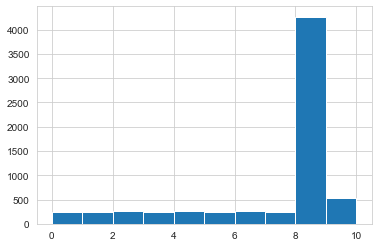

In [77]:
plt.hist(np.argmax(y_test, axis=-1))